# Model Selection (2)
Evaluating and selecting algorithms and hyperparameters.

In [1]:
# Global imports and settings
from preamble import *
%matplotlib inline
plt.rcParams['figure.dpi'] = 120 # Use 300 for PDF, 100 for slides
# InteractiveShell.ast_node_interactivity = "all"
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Evaluation Metrics and scoring
Keep the end-goal in mind

### Evaluation vs Optimization

- Each algorithm optimizes a given objective function (on the training data)
    - E.g. remember L2 loss in Ridge regression
$$L_{ridge} = \sum_{i}(y_i - \sum_{j} x_{i,j}w_j)^2 + \alpha \sum_{i} w_i^2$$
- The choice of function is limited by what can be efficiently optimized
    - E.g. gradient descent requires a differentiable loss function
- We _evaluate_ the resulting model with a score that makes sense in the real world
    - E.g. percentage of correct predictions (on a test set)
- We also tune the algorithm's hyperparameters to maximize that score

### Binary classification

- We have a positive and a negative class
- 2 different kind of errors:
    - False Positive (type I error): model predicts positive while the true label is negative
    - False Negative (type II error): model predicts negative while the true label is positive
- They are not always equally important
    - Which side do you want to err on for a medical test?

#### Confusion matrices

- We can represent all predictions (correct and incorrect) in a confusion matrix
    - n by n array (n is the number of classes)
    - Rows correspond to the true classes, columns to the predicted classes
    - Each entry counts how often a sample that belongs to the class corresponding to the row was classified as the class corresponding to the column.
    - For binary classification, we label these true negative (TN), true positive (TP), false negative (FN), false positive (FP)

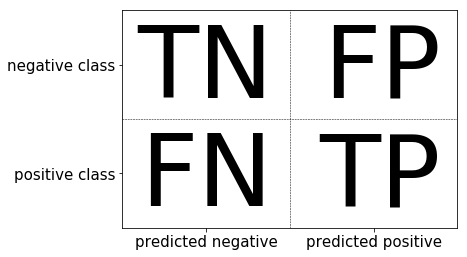

In [3]:
mglearn.plots.plot_binary_confusion_matrix()

#### Predictive accuracy

- Accuracy is one of the measures we can compute based on the confusion matrix:

\begin{equation}
\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}
\end{equation}

- In sklearn: use `confusion_matrix` and `accuracy_score` from `sklearn.metrics`.
- Accuracy is also the default evaluation measure for classification

In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
data = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    data.data, data.target, stratify=data.target, random_state=0)
lr = LogisticRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)

print("confusion_matrix(y_test, y_pred): \n", confusion_matrix(y_test, y_pred))
print("accuracy_score(y_test, y_pred): ", accuracy_score(y_test, y_pred))
print("model.score(X_test, y_test): ", lr.score(X_test, y_test))

confusion_matrix(y_test, y_pred): 
 [[49  4]
 [ 5 85]]
accuracy_score(y_test, y_pred):  0.9370629370629371
model.score(X_test, y_test):  0.9370629370629371


#### The problem with accuracy: imbalanced datasets

- The type of error plays an even larger role if the dataset is imbalanced
    - One class is much more frequent than the other, e.g. credit fraud
    - Is a 99.99% accuracy good enough? 
- Are these three models really equally good?

In [5]:
# From Applied Machine Learning
def plot_confusion_matrix(values, xlabel="predicted labels", ylabel="true labels", xticklabels=None,
                          yticklabels=None, cmap=None, vmin=None, vmax=None, ax=None,
                          fmt="{:.2f}", xtickrotation=45, norm=None):
    """Plot a matrix as heatmap with explicit numbers.
    Parameters
    ----------
    values : ndarray
        Two-dimensional array to visualize.
    xlabel : string, default=""
        Label for the x-axis.
    ylabel : string, default=""
        Label for the y-axis.
    xticklabels : list of string or None, default=None
        Tick labels for the x-axis.
    yticklabels : list of string or None, default=None
        Tick labels for the y-axis
    cmap : string or colormap
        Matpotlib colormap to use.
    vmin : int, float or None
        Minimum clipping value.
    vmax : int, float or None
        Maximum clipping value.
    ax : axes object or None
        Matplotlib axes object to plot into. If None, the current axes are
        used.
    fmt : string, default="{:.2f}"
        Format string to convert value to text.
    xtickrotation : float, default=45
        Rotation of the xticklabels.
    norm : matplotlib normalizer
        Normalizer passed to pcolor
    """
    import matplotlib.pyplot as plt
    if ax is None:
        ax = plt.gca()
    img = ax.pcolormesh(values, cmap=cmap, vmin=vmin, vmax=vmax, norm=norm)
    # this will allow us to access the pixel values:
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.set_xlim(0, values.shape[1])
    ax.set_ylim(0, values.shape[0])

    if xticklabels is None:
        xticklabels = [""] * values.shape[1]
    if yticklabels is None:
        yticklabels = [""] * values.shape[0]

    # +.5 makes the ticks centered on the pixels
    ax.set_xticks(np.arange(values.shape[1]) + .5)
    ax.set_xticklabels(xticklabels, ha="center", rotation=xtickrotation)
    ax.set_yticks(np.arange(values.shape[0]) + .5)
    ax.set_yticklabels(yticklabels, va="center")
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            # pixel bright: use black for number
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt.format(value), color=c, ha="center", va="center")
    ax.invert_yaxis()
    return ax

In [28]:
# Artificial 90-10 imbalanced target
y_true = np.zeros(100, dtype=int)
y_true[:10] = 1
y_pred_1 = np.zeros(100, dtype=int)
y_pred_2 = y_true.copy()
y_pred_2[10:20] = 1
y_pred_3 = y_true.copy()
y_pred_3[5:15] = 1 - y_pred_3[5:15]

def plot_measure(measure):
    fig, axes = plt.subplots(1, 3)
    for i, (ax, y_pred) in enumerate(zip(axes, [y_pred_1, y_pred_2, y_pred_3])):
        plot_confusion_matrix(confusion_matrix(y_true, y_pred), cmap='gray_r', ax=ax,
                              xticklabels=["P", "N"], yticklabels=["P", "N"], xtickrotation=0, vmin=0, vmax=100)
        ax.set_title("{}: {:.2f}".format(measure.__name__,measure(y_true, y_pred)))

    plt.tight_layout()
    
plt.rcParams['figure.dpi'] = 120 # Use 300 for PDF, 100 for slides

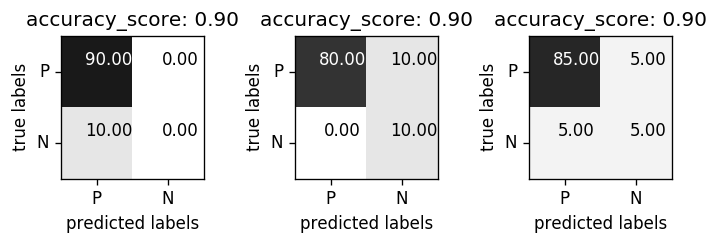

In [29]:
plot_measure(accuracy_score)

__Precision__ is used when the goal is to limit FPs
- Clinical trails: you only want to test drugs that really work
- Search engines: you want to avoid bad search results

\begin{equation}
\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
\end{equation}

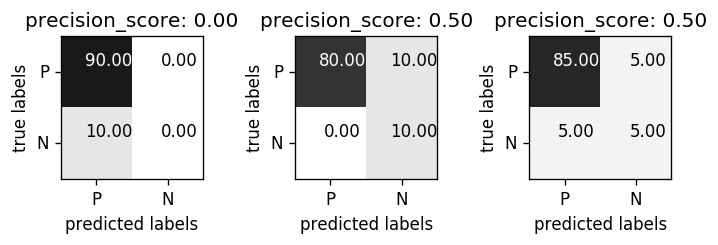

In [30]:
from sklearn.metrics import precision_score
plot_measure(precision_score)

__Recall__ is used when the goal is to limit FNs
- Cancer diagnosis: you don't want to miss a serious disease
- Search engines: You don't want to omit important hits
- Also know as sensitivity, hit rate, true positive rate (TPR)

\begin{equation}
\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
\end{equation}

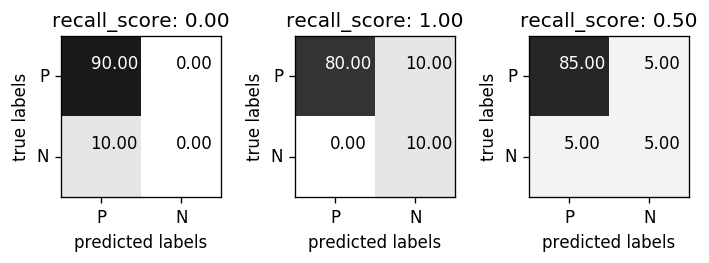

In [31]:
from sklearn.metrics import recall_score
plot_measure(recall_score)

__Comparison__   
![](images/07_precision-recall.jpg)
[//]: # "https://en.wikipedia.org/wiki/Precision_and_recall"

__F1-score__ or F1-measure trades off precision and recall:

\begin{equation}
\text{F1} = 2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}
\end{equation}

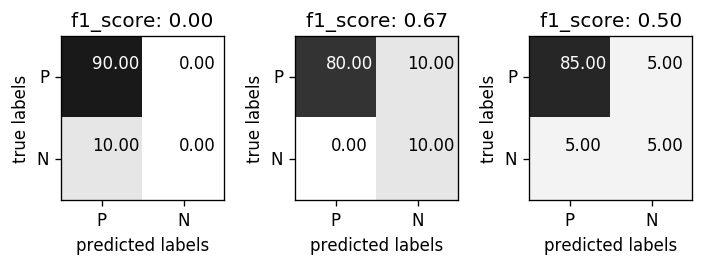

In [32]:
from sklearn.metrics import f1_score
plot_measure(f1_score)

__Classification measure Zoo__   
![](images/07_zoo.png)
https://en.wikipedia.org/wiki/Precision_and_recall"

- To study the scores _by class_, use `classification_report`
    - One class viewed as positive, other(s) als negative
    - Support: number of samples in each class
    - Last line: weighted average over the classes (weighted by number of samples in each class)
- Averaging for scoring measure R across C classes (also for multiclass):
    - micro: count total number of TP, FP, TN, FN
    - macro $$\frac{1}{C} \sum_{c \in C} R(y_c,\hat{y_c})$$
    - weighted ($w_c$: ratio of examples of class $c$) $$\sum_{c \in C} w_c R(y_c,\hat{y_c})$$

Example

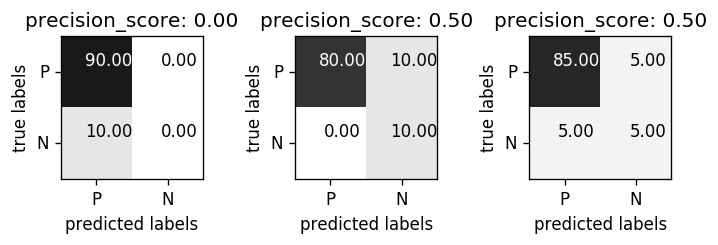

In [33]:
plot_measure(precision_score);

In [34]:
from sklearn.metrics import classification_report
for i, y_pred in enumerate([y_pred_1, y_pred_2, y_pred_3]):
    print('Matrix',i+1)
    print(classification_report(y_true, y_pred))

Matrix 1
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        90
           1       0.00      0.00      0.00        10

   micro avg       0.90      0.90      0.90       100
   macro avg       0.45      0.50      0.47       100
weighted avg       0.81      0.90      0.85       100

Matrix 2
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        90
           1       0.50      1.00      0.67        10

   micro avg       0.90      0.90      0.90       100
   macro avg       0.75      0.94      0.80       100
weighted avg       0.95      0.90      0.91       100

Matrix 3
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        90
           1       0.50      0.50      0.50        10

   micro avg       0.90      0.90      0.90       100
   macro avg       0.72      0.72      0.72       100
weighted avg       0.90      0.90      0.90    

## Taking uncertainty into account

- Remember that many classifiers actually return a probability per class
    - We can retrieve it with `decision_function` and `predict_proba`
- For binary classification, we threshold at 0 for  `decision_function` and 0.5 for `predict_proba` by default
- However, depending on the evaluation measure, you may want to threshold differently to fit your goals
    - For instance, when a FP is much worse than a FN
    - This is called _threshold calibration_

##### Visualization
- Imagine that we want to avoid misclassifying a red point
- Points within decision boundary (black line) are classified positive (red)
- Lowering the decision treshold (bottom figure): fewer FN, more FP

In [35]:
from sklearn.svm import SVC
from mglearn.datasets import make_blobs 
X, y = make_blobs(n_samples=(400, 50), centers=2, cluster_std=[7.0, 2],        
                  random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
svc = SVC(gamma=.5).fit(X_train, y_train)                                     

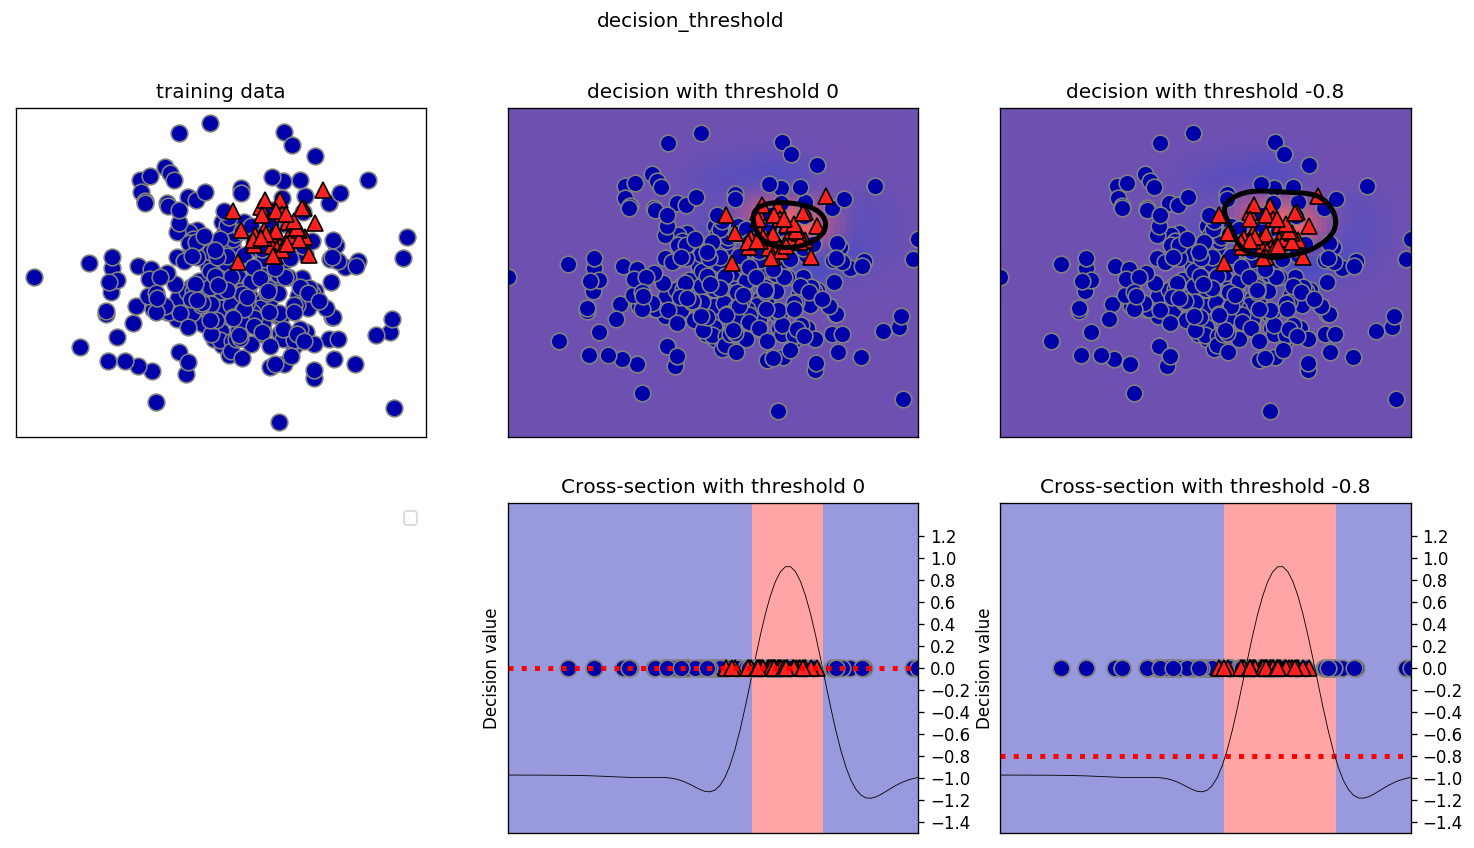

In [36]:
mglearn.plots.plot_decision_threshold()

- Studying the classification report, we see that lowering the threshold yields:
    - higher recall for class 1 (we risk more FPs in exchange for more TP)
    - lower precision for class 1
- We can often trade off precision for recall

In [37]:
print("Threshold 0")
print(classification_report(y_test, svc.predict(X_test)))

Threshold 0
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        96
           1       0.67      0.47      0.55        17

   micro avg       0.88      0.88      0.88       113
   macro avg       0.79      0.71      0.74       113
weighted avg       0.87      0.88      0.88       113



In [38]:
print("Threshold -0.8")
y_pred_lower_threshold = svc.decision_function(X_test) > -.8
print(classification_report(y_test, y_pred_lower_threshold))  

Threshold -0.8
              precision    recall  f1-score   support

           0       0.98      0.92      0.95        96
           1       0.65      0.88      0.75        17

   micro avg       0.91      0.91      0.91       113
   macro avg       0.81      0.90      0.85       113
weighted avg       0.93      0.91      0.92       113



### Precision-Recall curves

- The best threshold depends on your application, should be driven by real-world goals.
- You can have arbitrary high recall, but you often want reasonable precision, too.
- It is not clear beforehand where the optimale trade-off (or _operating point_) will be, so it is useful to look at all possible thresholds
- Plotting precision against recall for all thresholds yields a __precision-recall curve__

- In scikit-learn, this is included in the `sklearn.metrics` module
- Returns all precision and recall values for all thresholds
    - Vary threshold from lowest to highest decision function score in the predictions
    - Or from highest to lowest class probability

In [39]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(
    y_test, svc.decision_function(X_test)) 

- The default tradeoff (chosen by the `predict` method) is shown as _threshold zero_.
    - Higher threshold, more precision (move left)
    - Lower threshold, more recall (move right)
- The closer the curve stays to the upper-right corner, the better
    - High precision and high recall
- Here, it is possible to still get a precision of 0.5 with high recall

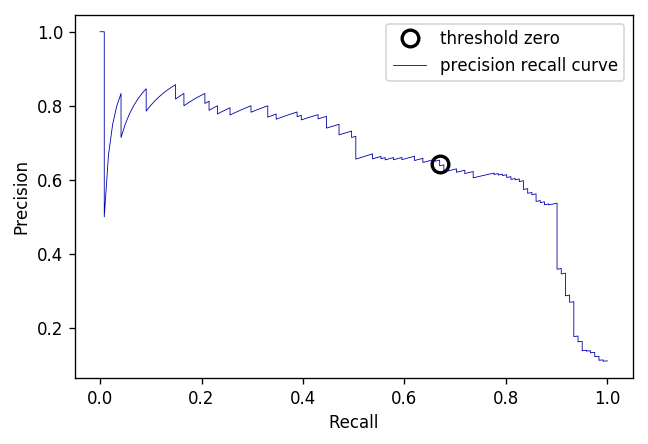

In [40]:
# create a similar dataset as before, but with more samples
# to get a smoother curve
X, y = make_blobs(n_samples=(4000, 500), centers=2, cluster_std=[7.0, 2],
                  random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

svc = SVC(gamma=.05).fit(X_train, y_train)

precision, recall, thresholds = precision_recall_curve(
    y_test, svc.decision_function(X_test))
# find threshold closest to zero:
close_zero = np.argmin(np.abs(thresholds))
plt.plot(recall[close_zero], precision[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)

plt.plot(recall, precision, label="precision recall curve")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend(loc="best");

#### Model selection

- Different classifiers work best in different parts of the curve (at different operating points)
- RandomForest (in red) performs better at the extremes, SVM better in center
- The area under the precision-recall curve (AUPRC) is often used as a general evaluation measure

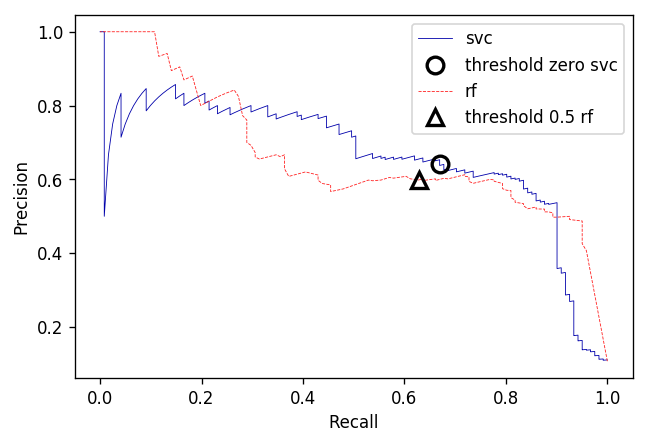

In [41]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=0, max_features=2)
rf.fit(X_train, y_train)

# RandomForestClassifier has predict_proba, but not decision_function
# Only pass probabilities for the positive class
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(
    y_test, rf.predict_proba(X_test)[:, 1])

plt.plot(recall, precision, label="svc")

plt.plot(recall[close_zero], precision[close_zero], 'o', markersize=10,
         label="threshold zero svc", fillstyle="none", c='k', mew=2)

plt.plot(recall_rf, precision_rf, label="rf")

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot( recall_rf[close_default_rf], precision_rf[close_default_rf], '^', c='k',
         markersize=10, label="threshold 0.5 rf", fillstyle="none", mew=2)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend(loc="best");

Note that the F1-measure completely misses these subtleties

In [42]:
print("f1_score of random forest: {:.3f}".format(
        f1_score(y_test, rf.predict(X_test))))
print("f1_score of svc: {:.3f}".format(f1_score(y_test, svc.predict(X_test))))

f1_score of random forest: 0.610
f1_score of svc: 0.656


- The area under the precision-recall curve is returned by the `average_precision_score` measure 
    - It's actually a close approximation of the actual area
- This is a good automatic measure, but also hides the subtleties

In [43]:
from sklearn.metrics import average_precision_score
ap_rf = average_precision_score(y_test, rf.predict_proba(X_test)[:, 1])
ap_svc = average_precision_score(y_test, svc.decision_function(X_test))
print("Average precision of random forest: {:.3f}".format(ap_rf))
print("Average precision of svc: {:.3f}".format(ap_svc))

Average precision of random forest: 0.660
Average precision of svc: 0.666


### Receiver Operating Characteristics (ROC) and AUC

- There is another trade-off between recall (true positive rate, TPR) and the false positive rate (FPR).
- The 2D space created by TPR and FPR is called the Receiver Operating Characteristics (ROC) space
- A model will be at one point in this ROC space

\begin{equation}
\text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}}
\end{equation}

\begin{equation}
\text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}
\end{equation}

- Varying the decision threshold yields the ROC curve
- It can be computed with the `roc_curve` function
    - Lower threshold, more recall/TPR, move right
    - High threshold, fewer FPs, move left
- Ideal is close to the top left: high recall, low FPR
- Inspect the curve to find the preferred calibration
    - Here, we can get much higher recall with slightly worse FPR

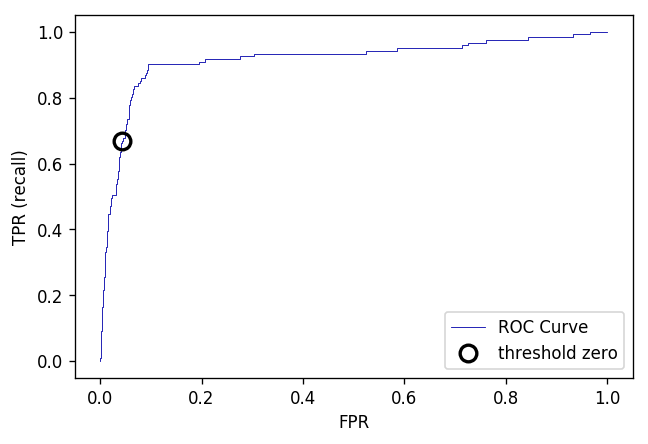

In [44]:
plt.rcParams['savefig.dpi'] = 100 # Use 300 for PDF, 100 for slides
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test))

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
# find threshold closest to zero:
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4);

#### Visualization

- The blue probability density shows the probability p(x) that the model predicts blue if a data point has a certain predicted probability x to be blue. Same for red.
- In a random classifier the probability densities completely overlap.
- All points with a predicted probability higher than the threshold are predicted positive, others negative
- As we increase the threshold, we'll get fewer FPs, more FNs. We move from right to left along the ROC curve.

![roc](images/03_roc.png)

#### ROC Isometrics
- Different _costs_ can be involved for FP and FN
- This yields different _isometrics_ (lines of equal cost) in ROC space
- The optimal threshold is the point on the ROC curve where the cost in minimal
    - If a FP and FN are weigthed equally, cost lines follow the diagonal (blue line)
    - If a FP is 10 times worse than a FN: pink line
    - IF a FN is 10 times worse than a FP: red line

![ROC cost curves](images/03_roc_cost.png)

#### Model selection

- Again, we can compare multiple models by looking at the ROC curves
- We can calibrate the threshold depending on whether we need high recall or low FPR
- We can select between algorithms (or hyperparameters) depending on the involved costs.

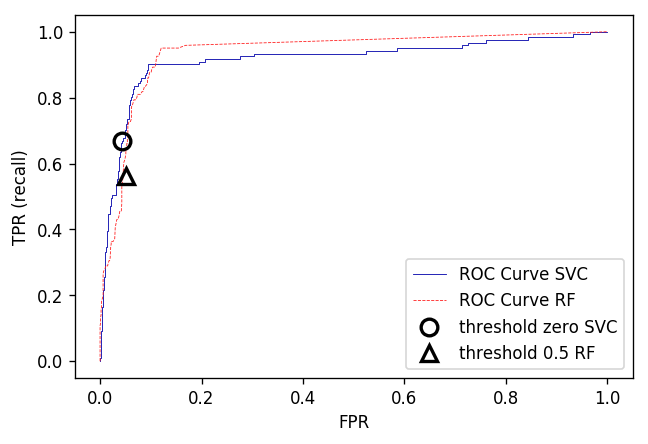

In [45]:
from sklearn.metrics import roc_curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])

plt.plot(fpr, tpr, label="ROC Curve SVC")
plt.plot(fpr_rf, tpr_rf, label="ROC Curve RF")

plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero SVC", fillstyle="none", c='k', mew=2)
close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(fpr_rf[close_default_rf], tpr[close_default_rf], '^', markersize=10,
         label="threshold 0.5 RF", fillstyle="none", c='k', mew=2)

plt.legend(loc=4);

#### Area under the ROC curve

- A good summary measure is the area under the ROC curve (AUROC or AUC)
- Compute using the `roc_auc_score` 
    - Don't use `auc` (uses less accurate trapezoidal rule)

In [46]:
from sklearn.metrics import roc_auc_score
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
svc_auc = roc_auc_score(y_test, svc.decision_function(X_test))
print("AUC for Random Forest: {:.3f}".format(rf_auc))
print("AUC for SVC: {:.3f}".format(svc_auc))

AUC for Random Forest: 0.937
AUC for SVC: 0.916


#### Imbalanced classes
- AUC is popular because it is insensitive to class imbalance
    - Random guessing always yields TPR=FPR
    - All points are on the diagonal line, hence an AUC of 0.5
    - Hint: use the visualization of TPR,FPR to see this
- Example: unbalanced digits
    - 3 models, ACC is the same, AUC not
    - If we optimize for ACC, our model could be just random guessing

gamma = 1.000  accuracy = 0.90  AUC = 0.5000
gamma = 0.100  accuracy = 0.90  AUC = 0.9582
gamma = 0.010  accuracy = 0.90  AUC = 0.9995


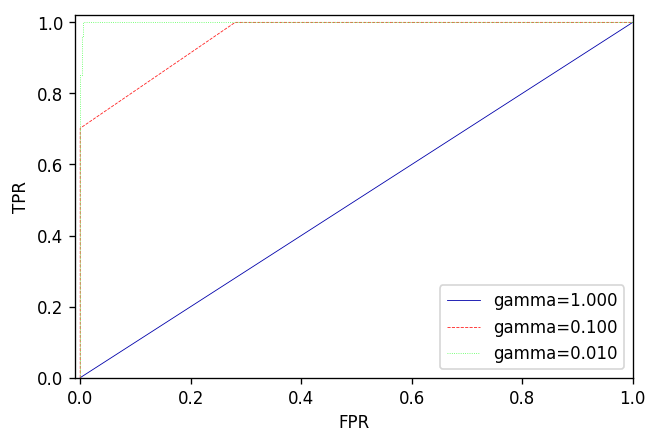

In [59]:
from sklearn.datasets import load_digits

digits = load_digits()
y = digits.target == 9

X_train, X_test, y_train, y_test = train_test_split(
    digits.data, y, random_state=0)

plt.figure()  

for gamma in [1, 0.1, 0.01]:
    svc = SVC(gamma=gamma).fit(X_train, y_train)
    accuracy = svc.score(X_test, y_test)
    auc = roc_auc_score(y_test, svc.decision_function(X_test))
    fpr, tpr, _ = roc_curve(y_test , svc.decision_function(X_test))
    print("gamma = {:.3f}  accuracy = {:.2f}  AUC = {:.4f}".format(
            gamma, accuracy, auc))
    plt.plot(fpr, tpr, label="gamma={:.3f}".format(gamma))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(-0.01, 1)
plt.ylim(0, 1.02)
plt.legend(loc="best");

#### Take home message

- AUC is highly recommended, especially on imbalanced data
- Remember to calibrate the threshold to your needs

### Multi-class classification

- Multiclass metrics are derived from binary metrics, averaged over all classes
- Let's consider the full (10-class) handwritten digit recognition data

Confusion matrix

In [49]:
from sklearn.metrics import accuracy_score
digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target, random_state=0)
lr = LogisticRegression().fit(X_train, y_train)
pred = lr.predict(X_test)
print("Accuracy: {:.3f}".format(accuracy_score(y_test, pred)))
print("Confusion matrix:\n{}".format(confusion_matrix(y_test, pred)))

Accuracy: 0.953
Confusion matrix:
[[37  0  0  0  0  0  0  0  0  0]
 [ 0 39  0  0  0  0  2  0  2  0]
 [ 0  0 41  3  0  0  0  0  0  0]
 [ 0  0  1 43  0  0  0  0  0  1]
 [ 0  0  0  0 38  0  0  0  0  0]
 [ 0  1  0  0  0 47  0  0  0  0]
 [ 0  0  0  0  0  0 52  0  0  0]
 [ 0  1  0  1  1  0  0 45  0  0]
 [ 0  3  1  0  0  0  0  0 43  1]
 [ 0  0  0  1  0  1  0  0  1 44]]


Visualized as a heatmap

- Which digits are easy to predict? Which ones are confused? 

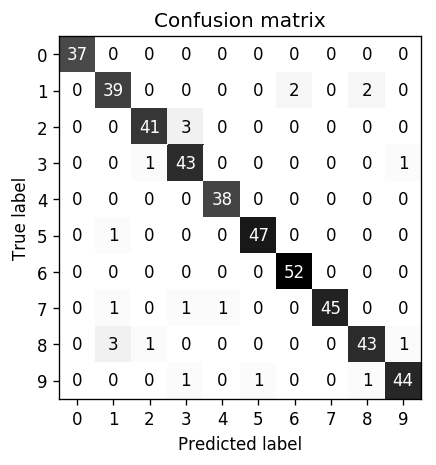

In [50]:
scores_image = mglearn.tools.heatmap(
    confusion_matrix(y_test, pred), xlabel='Predicted label',
    ylabel='True label', xticklabels=digits.target_names,
    yticklabels=digits.target_names, cmap=plt.cm.gray_r, fmt="%d")    
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

Precision, recall, F1-score now yield 10 per-class scores

In [51]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.89      0.91      0.90        43
           2       0.95      0.93      0.94        44
           3       0.90      0.96      0.92        45
           4       0.97      1.00      0.99        38
           5       0.98      0.98      0.98        48
           6       0.96      1.00      0.98        52
           7       1.00      0.94      0.97        48
           8       0.93      0.90      0.91        48
           9       0.96      0.94      0.95        47

   micro avg       0.95      0.95      0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450



Different ways to compute average

- macro-averaging: computes unweighted per-class scores: 
$\frac{\sum_{i=0}^{n}score_i}{n}$
    - Use when you care about each class equally much

- weighted averaging: scores are weighted by the relative size of the classes (support): 
$\frac{\sum_{i=0}^{n}score_i weight_i}{n}$
    - Use when data is imbalanced

- micro-averaging: computes total number of FP, FN, TP over all classes, then computes scores using these counts: 
$recall = \frac{\sum_{i=0}^{n}TP_i}{\sum_{i=0}^{n}TP_i + \sum_{i=0}^{n}FN_i}$
    - Use when you care about each sample equally much

In [52]:
print("Micro average f1 score: {:.3f}".format(f1_score(y_test, pred, average="micro")))
print("Weighted average f1 score: {:.3f}".format(f1_score(y_test, pred, average="weighted")))
print("Macro average f1 score: {:.3f}".format(f1_score(y_test, pred, average="macro")))

Micro average f1 score: 0.953
Weighted average f1 score: 0.953
Macro average f1 score: 0.954


## Regression metrics

Most commonly used are
- (root) mean squared error: $\frac{\sum_{i}(y_{pred_i}-y_{actual_i})^2}{n}$
- mean absolute error: $\frac{\sum_{i}|y_{pred_i}-y_{actual_i}|}{n}$
    - Less sensitive to outliers and large errors
- R squared (r2): $1 - \frac{\sum_{i}(y_{pred_i}-y_{actual_i})^2}{\sum_{i}(y_{mean}-y_{actual_i})^2}$
    - Ratio of variation explained by the model / total variation
    - Between 0 and 1, but _negative_ if the model is worse than just predicting the mean
    - Easier to interpret (higher is better).

- R squared: 1 - ratio of $\sum_{i}(y_{pred_i}-y_{actual_i})^2$ (blue) and $\sum_{i}(y_{mean}-y_{actual_i})^2$ (red)
![r2](images/07_r2.png)

#### Visualizing errors
* Prediction plot (left): predicted vs actual target values
* Residual plot (right): residuals vs actual target values
    * Over- and underpredictions can be given different costs 

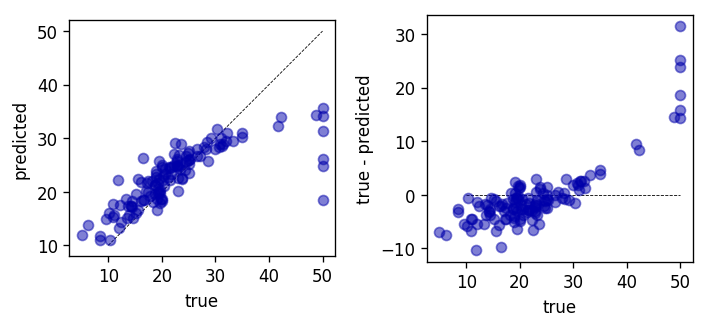

In [71]:
from sklearn.linear_model import Ridge
from sklearn.datasets import load_boston
boston = load_boston()

X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target)

pred = Ridge(normalize=True).fit(X_train, y_train).predict(X_test)

plt.subplot(1, 2, 1)
plt.gca().set_aspect("equal")
plt.plot([10, 50], [10, 50], '--', c='k')
plt.plot(y_test, pred, 'o', alpha=.5)
plt.ylabel("predicted")
plt.xlabel("true");

plt.subplot(1, 2, 2)
plt.gca().set_aspect("equal")
plt.plot([10, 50], [0,0], '--', c='k')
plt.plot(y_test, y_test - pred, 'o', alpha=.5)
plt.xlabel("true")
plt.ylabel("true - predicted")
plt.tight_layout();

## Using evaluation metrics in model selection

- You typically want to use AUC or other relevant measures in `cross_val_score` and `GridSearchCV` instead of the default accuracy.
- scikit-learn makes this easy through the `scoring` argument
    - But, you need to need to look the [mapping between the scorer and the metric](http://scikit-learn.org/stable/modules/model_evaluation.html#model-evaluation)

![scorers](images/03_scoring.png)

Or simply look up like this:

In [53]:
from sklearn.metrics.scorer import SCORERS
print("Available scorers:\n{}".format(sorted(SCORERS.keys())))

Available scorers:
['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'brier_score_loss', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'mutual_info_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'v_measure_score']


Cross-validation with accuracy and AUC

In [57]:
from sklearn.model_selection import cross_val_score, GridSearchCV
# default scoring for classification is accuracy
print("Default scoring: {}".format(
      cross_val_score(SVC(), digits.data, digits.target == 9)))
# providing scoring="accuracy" doesn't change the results
explicit_accuracy =  cross_val_score(SVC(), digits.data, digits.target == 9, 
                                     scoring="accuracy")
print("Explicit accuracy scoring: {}".format(explicit_accuracy))
roc_auc =  cross_val_score(SVC(), digits.data, digits.target == 9,
                           scoring="roc_auc")
print("AUC scoring: {}".format(roc_auc))

Default scoring: [0.9 0.9 0.9]
Explicit accuracy scoring: [0.9 0.9 0.9]
AUC scoring: [0.994 0.99  0.996]


Grid Search with accuracy and AUC

- With accuracy, gamma=0.0001 is selected
- With AUC, gamma=0.01 is selected
    - Actually has better accuracy on the test set

In [72]:
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target == 9, random_state=0)

# we provide a somewhat bad grid to illustrate the point:
param_grid = {'gamma': [0.0001, 0.01, 0.1, 1, 10]}
# using the default scoring of accuracy:
grid = GridSearchCV(SVC(), param_grid=param_grid)
grid.fit(X_train, y_train)
print("Grid-Search with accuracy")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (accuracy)): {:.3f}".format(grid.best_score_))
print("Test set AUC: {:.3f}".format(
        roc_auc_score(y_test, grid.decision_function(X_test))))
print("Test set accuracy: {:.3f}".format(grid.score(X_test, y_test)))

# using AUC scoring instead:
grid = GridSearchCV(SVC(), param_grid=param_grid, scoring="roc_auc")
grid.fit(X_train, y_train)
print("\nGrid-Search with AUC")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (AUC): {:.3f}".format(grid.best_score_))
print("Test set AUC: {:.3f}".format(
        roc_auc_score(y_test, grid.decision_function(X_test))))
print("Test set accuracy: {:.3f}".format(grid.score(X_test, y_test)))

Grid-Search with accuracy
Best parameters: {'gamma': 0.0001}
Best cross-validation score (accuracy)): 0.970
Test set AUC: 0.992
Test set accuracy: 0.973

Grid-Search with AUC
Best parameters: {'gamma': 0.01}
Best cross-validation score (AUC): 0.997
Test set AUC: 1.000
Test set accuracy: 1.000


## Final thoughts
* There exist techniques to correct label imbalance
    - Undersample the majority class, or oversample the minority class
    - SMOTE (Synthetic Minority Oversampling TEchnique) adds articifial _training_ points by interpolating existing minority class points
        - Think twice before creating 'artificial' training data 
* Cost-sensitive classification (not in sklearn)
    - _Cost matrix_: a confusion matrix with a costs associated to every possible type of error
    - Some algorithms allow optimizing on these costs instead of their usual loss function
    - Meta-cost: builds ensemble of models by relabeling training sets to match a given cost matrix
        - Black-box: can make any algorithm cost sensitive (but slower and less accurate)

## Final thoughts
* There are many more metrics to choose from
    - Cohen's Kappa: accuracy, taking into account the possibility of predicting the right class by chance
        - 1: perfect prediction, 0: random prediction, negative: worse than random
        - With $p_0$ = accuracy, and $p_e$ = accuracy of random classifier:
            $$\kappa = \frac{p_o - p_e}{1 - p_e}$$
    - Balanced accuracy: accuracy where each sample is weighted according to the inverse prevalence of its true class
        - Identical to macro-averaged recall
    - Matthews correlation coefficient: another measure that can be used on imbalanced data
        - 1: perfect prediction, 0: random prediction, -1: inverse prediction
            $$MCC = \frac{tp \times tn - fp \times fn}{\sqrt{(tp + fp)(tp + fn)(tn + fp)(tn + fn)}}$$


# Summary
* Real-world data is often imbalanced 
* False positives may be much worse than false negatives (or vise-versa)
* Binary classification
    - Select metrics that can distinguish different types of errors (precision, recall, f1-score, AUC,...)
    - Calibrate decision thresholds to the task at hand
    - Precision-Recall and ROC curves: choose the best threshold or take area under the curve
* Multiclass classification
    - Macro/Micro/weighted average of per-class scores (one-vs-all)
* Regression
    - (Root) mean squared/absolute error from 0..Inf
    - R2 easier to interpret
* All measures can be used in cross-validation or grid/random search
* Cost-sensitive classification: optimize for any cost matrix or cost function